# Sequentially Comparing *Lagged* Forecasters on Synthetic Data

Here, we plot our time-uniform empirical-Bernstein (EB) and Hoeffding CSs on various synthetic sequential (non-iid, time-varying) forecast comparison scenarios. We also provide comparisons against a fixed-time CI ([Lai et al., 2011](https://doi.org/10.1214/11-AOS902)).

See also: Section F in our paper.

YJ Choe [yjchoe@cmu.edu]

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os.path

import comparecast as cc

## Hyperparameter Settings

In [2]:
# which scoring rule to use
scoring_rule = "brier"

# significance level
alpha = 0.05

# whether to use the log scale on x-axis (time)
use_logx = False

# size up label fonts
font_scale = 1.75

# RNG
rng = np.random.default_rng(1234)

## Forecasts on Synthetic Data

The synthetic data as well as the forecasts are generated from the command line via:
```shell
# changepoints evenly spaced in regular scale (default)
python forecast.py -d default -n 10000 -f all -o forecasts/default.csv -p plots/default
# changepoints evenly spaced in log scale
python forecast.py -d default_logt -n 10000 -f all -o forecasts/default_logt.csv -p plots/default_logt
```

In [3]:
data_name = "default"
data_file = f"forecasts/{data_name}.csv"
plots_dir = f"plots/{data_name}/{scoring_rule}-lagged"

data = cc.data_utils.synthetic.get_data(data_file)
data

,time,y,true_probs,laplace,k29_poly3,k29_rbf0.01,constant_0.5,constant_0,constant_1,random,mix_01_noiseless,mix_01,mix_10_noiseless,mix_10
0,1,0,0.512573,0.500000,0.500000,0.500000,0.5,0.0,1.0,0.737568,0.2,0.676700,0.8,1.000000
1,2,0,0.486790,0.250000,0.000000,0.000000,0.5,0.0,1.0,0.520202,0.2,0.080196,0.8,0.519801
2,3,1,0.564042,0.166667,0.000000,0.000000,0.5,0.0,1.0,0.246811,0.2,0.623246,0.8,1.000000
3,4,1,0.510490,0.375000,0.000000,0.000000,0.5,0.0,1.0,0.559666,0.2,0.000000,0.8,1.000000
4,5,1,0.446433,0.500000,1.000000,1.000000,0.5,0.0,1.0,0.903658,0.2,0.019097,0.8,0.483560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0,0.333804,0.503351,0.179688,0.223633,0.5,0.0,1.0,0.065758,0.8,0.645279,0.2,0.084745
9996,9997,0,0.155623,0.503301,0.176758,0.222656,0.5,0.0,1.0,0.283446,0.8,0.779568,0.2,0.370971
9997,9998,0,0.158363,0.503251,0.174805,0.221680,0.5,0.0,1.0,0.610947,0.8,1.000000,0.2,0.000000
9998,9999,0,0.073370,0.503200,0.172852,0.221680,0.5,0.0,1.0,0.162384,0.8,0.475797,0.2,0.309197


We also add a few more (data-specific) forecasters that have changepoints and also some noise.

In [4]:
if "mix_01" not in data:
    data["mix_01_noiseless"] = np.concatenate([
        np.repeat(0.2, 6000),
        np.repeat(0.8, 4000),
    ])
    data["mix_01"] = (
        data["mix_01_noiseless"] + 
        rng.uniform(-0.5, 0.5, size=10000)
    ).clip(0, 1)
    data["mix_10_noiseless"] = np.concatenate([
        np.repeat(0.8, 6000),
        np.repeat(0.2, 4000),
    ])
    data["mix_10"] = (
        data["mix_10_noiseless"] + 
        rng.uniform(-0.5, 0.5, size=10000)
    ).clip(0, 1)
    
    # overwrite data
    data.to_csv(data_file, index=False)

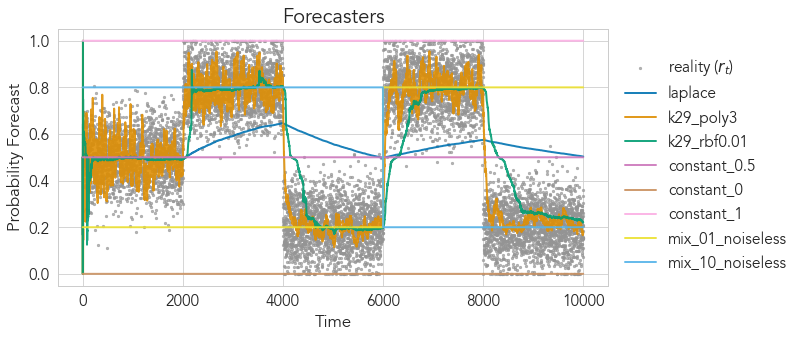

In [5]:
cc.plot_forecasts(
    data, 
    forecasters=["laplace", "k29_poly3", "k29_rbf0.01", 
                 "constant_0.5", "constant_0", "constant_1", 
                 "mix_01_noiseless", "mix_10_noiseless"], 
    plots_dir=plots_dir, 
    use_logx=use_logx,
    font_scale=font_scale,
)

## *Add lag to data

$y_t$ is one-step ahead, $y_{t+1}$ is two-step ahead, ...

In [6]:
LAG = 5
data["y"] = data["y"].shift(LAG - 1)
data

,time,y,true_probs,laplace,k29_poly3,k29_rbf0.01,constant_0.5,constant_0,constant_1,random,mix_01_noiseless,mix_01,mix_10_noiseless,mix_10
0,1,NaN,0.512573,0.500000,0.500000,0.500000,0.5,0.0,1.0,0.737568,0.2,0.676700,0.8,1.000000
1,2,NaN,0.486790,0.250000,0.000000,0.000000,0.5,0.0,1.0,0.520202,0.2,0.080196,0.8,0.519801
2,3,NaN,0.564042,0.166667,0.000000,0.000000,0.5,0.0,1.0,0.246811,0.2,0.623246,0.8,1.000000
3,4,NaN,0.510490,0.375000,0.000000,0.000000,0.5,0.0,1.0,0.559666,0.2,0.000000,0.8,1.000000
4,5,0.0,0.446433,0.500000,1.000000,1.000000,0.5,0.0,1.0,0.903658,0.2,0.019097,0.8,0.483560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,0.0,0.333804,0.503351,0.179688,0.223633,0.5,0.0,1.0,0.065758,0.8,0.645279,0.2,0.084745
9996,9997,1.0,0.155623,0.503301,0.176758,0.222656,0.5,0.0,1.0,0.283446,0.8,0.779568,0.2,0.370971
9997,9998,0.0,0.158363,0.503251,0.174805,0.221680,0.5,0.0,1.0,0.610947,0.8,1.000000,0.2,0.000000
9998,9999,0.0,0.073370,0.503200,0.172852,0.221680,0.5,0.0,1.0,0.162384,0.8,0.475797,0.2,0.309197


## CS for $\Delta_t^{(h)}$

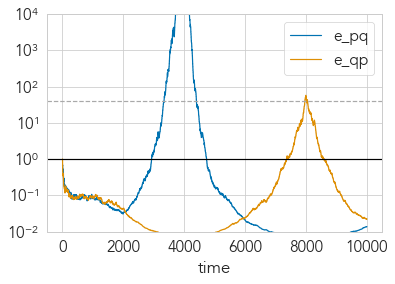

In [16]:
#name_p, name_q = "k29_poly3", "constant_0.5"
name_p, name_q = "mix_10", "mix_01"
results = cc.compare_forecasts(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,
    alpha=alpha,
    lag=LAG,
    lagged_null="w",
    c=0.01,
    aligned_outcomes=False,
    compute_cs=False,
    no_calibration=True,
)
ax = results.plot(x="time", y=["e_pq", "e_qp"])
ax.axhline(y=1, color="black", linestyle="solid")
ax.axhline(y=40, color="darkgray", linestyle="dashed")
ax.set(yscale="log", ylim=(10**-2, 10**4))
None

calculating diagnostics under repeated sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.91it/s]


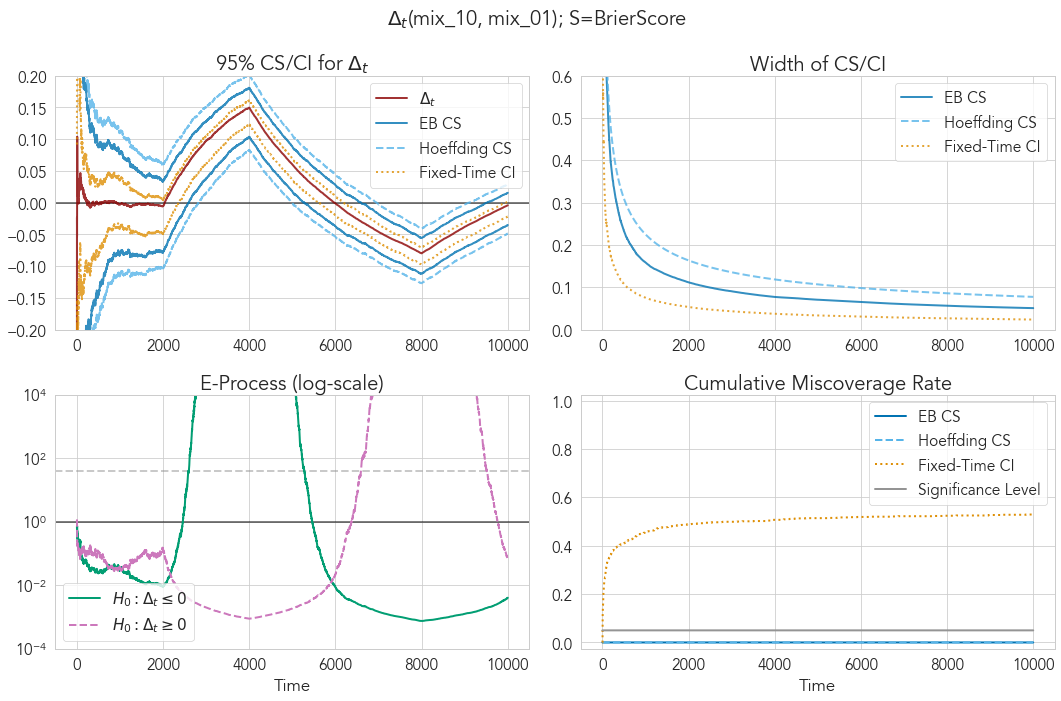

In [7]:
name_p, name_q = "mix_10", "mix_01"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "ci"),
    use_logx=use_logx,
    ylim_scale=0.2,
    font_scale=font_scale,
)

## Examing Interesting Scenarios

We're interested in three particular cases:
- $p$ is strictly better than $q$ always (e.g., true_probs vs random);
- $p$ and $q$ are alternatingly good;
- $p$ is "usually" but not always better than $q$ (say, better 80% of the time and worse 20% of the time).

### Case 1: $p$ is strictly better than $q$

$\Delta_t(p; q)$ is positive, as $S(p, y)$ is smaller than $S(q, y)$.

/Users/yjchoe/Dropbox/Code/ComparingForecasters/comparecast/eprocess.py:44: RuntimeWarning: divide by zero encountered in log
  + np.log(gammainc(v_rho_csq, np.maximum(1e-8, cs_v_rho_csq)))
calculating diagnostics under repeated sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 264.71it/s]


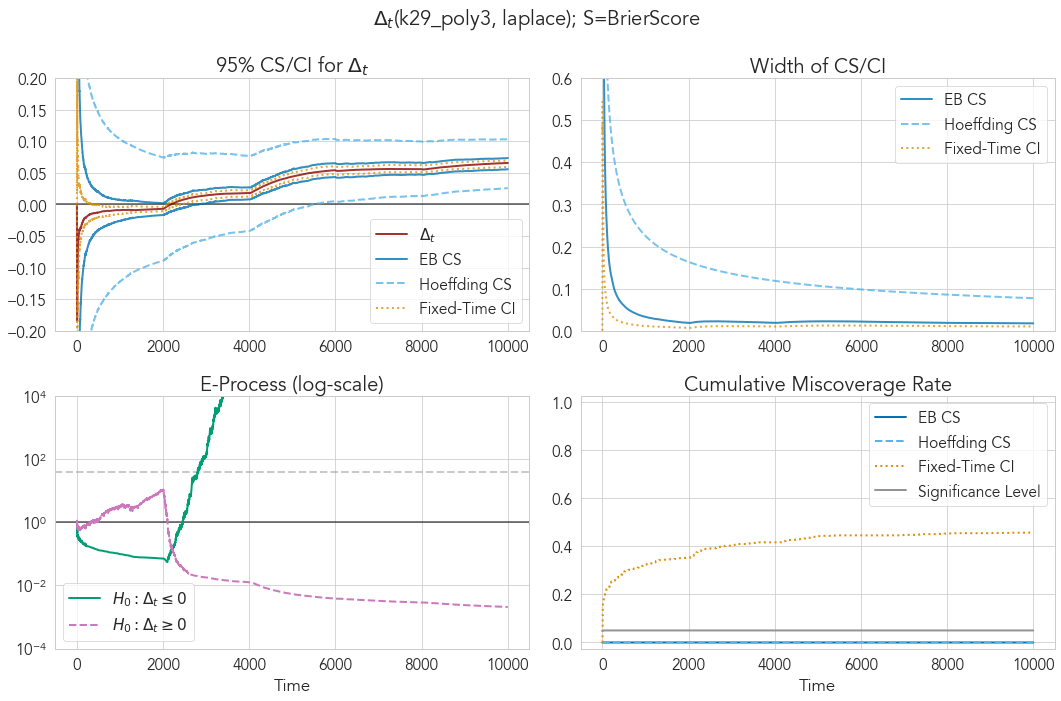

In [9]:
name_p = "k29_poly3"
name_q = "laplace"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "ci"),
    use_logx=use_logx,
    ylim_scale=0.2,
    font_scale=font_scale,
)

### Case 2: $p$ and $q$ are alternatingly good

$\Delta_t$ changes signs over time, and no forecaster dominates the other at the end.

calculating diagnostics under repeated sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 269.64it/s]


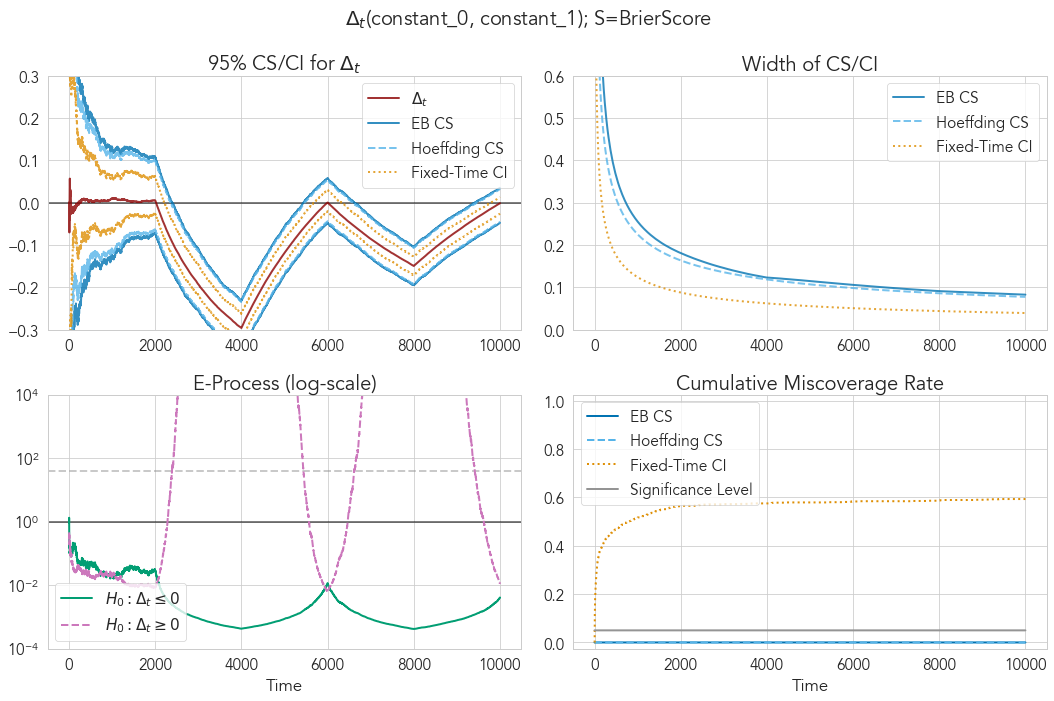

In [10]:
# near-noiseless; not ideal for EB CS
name_p = "constant_0"
name_q = "constant_1"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "ci"),
    use_logx=use_logx,
    ylim_scale=0.3,
    font_scale=font_scale,
)

### Case 3: $p$ is usually better than $q$, but not always

$\Delta_t(p, q)$ is positive, but it is closer to zero than case 1.

calculating diagnostics under repeated sampling: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 274.15it/s]


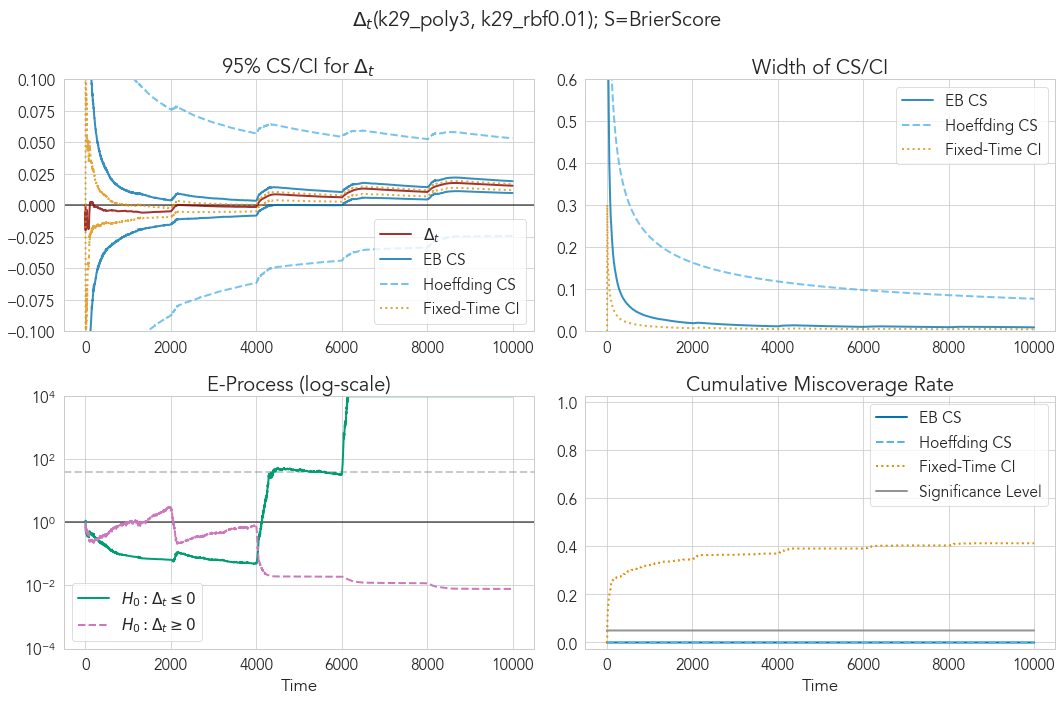

In [11]:
name_p = "k29_poly3"
name_q = "k29_rbf0.01"
results, axes = cc.plot_comparison(
    data, 
    name_p, 
    name_q, 
    scoring_rule=scoring_rule,    
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h", "ci"),
    plot_e=True,
    plot_width=True,
    plot_diagnostics=True,
    diagnostics_fn="miscoverage",
    diagnostics_baselines=("h", "ci"),
    use_logx=use_logx,
    ylim_scale=0.1,
    font_scale=font_scale,
)

## Comparing Many Forecasters

We now compare all pairs between four forecasters for this dataset.

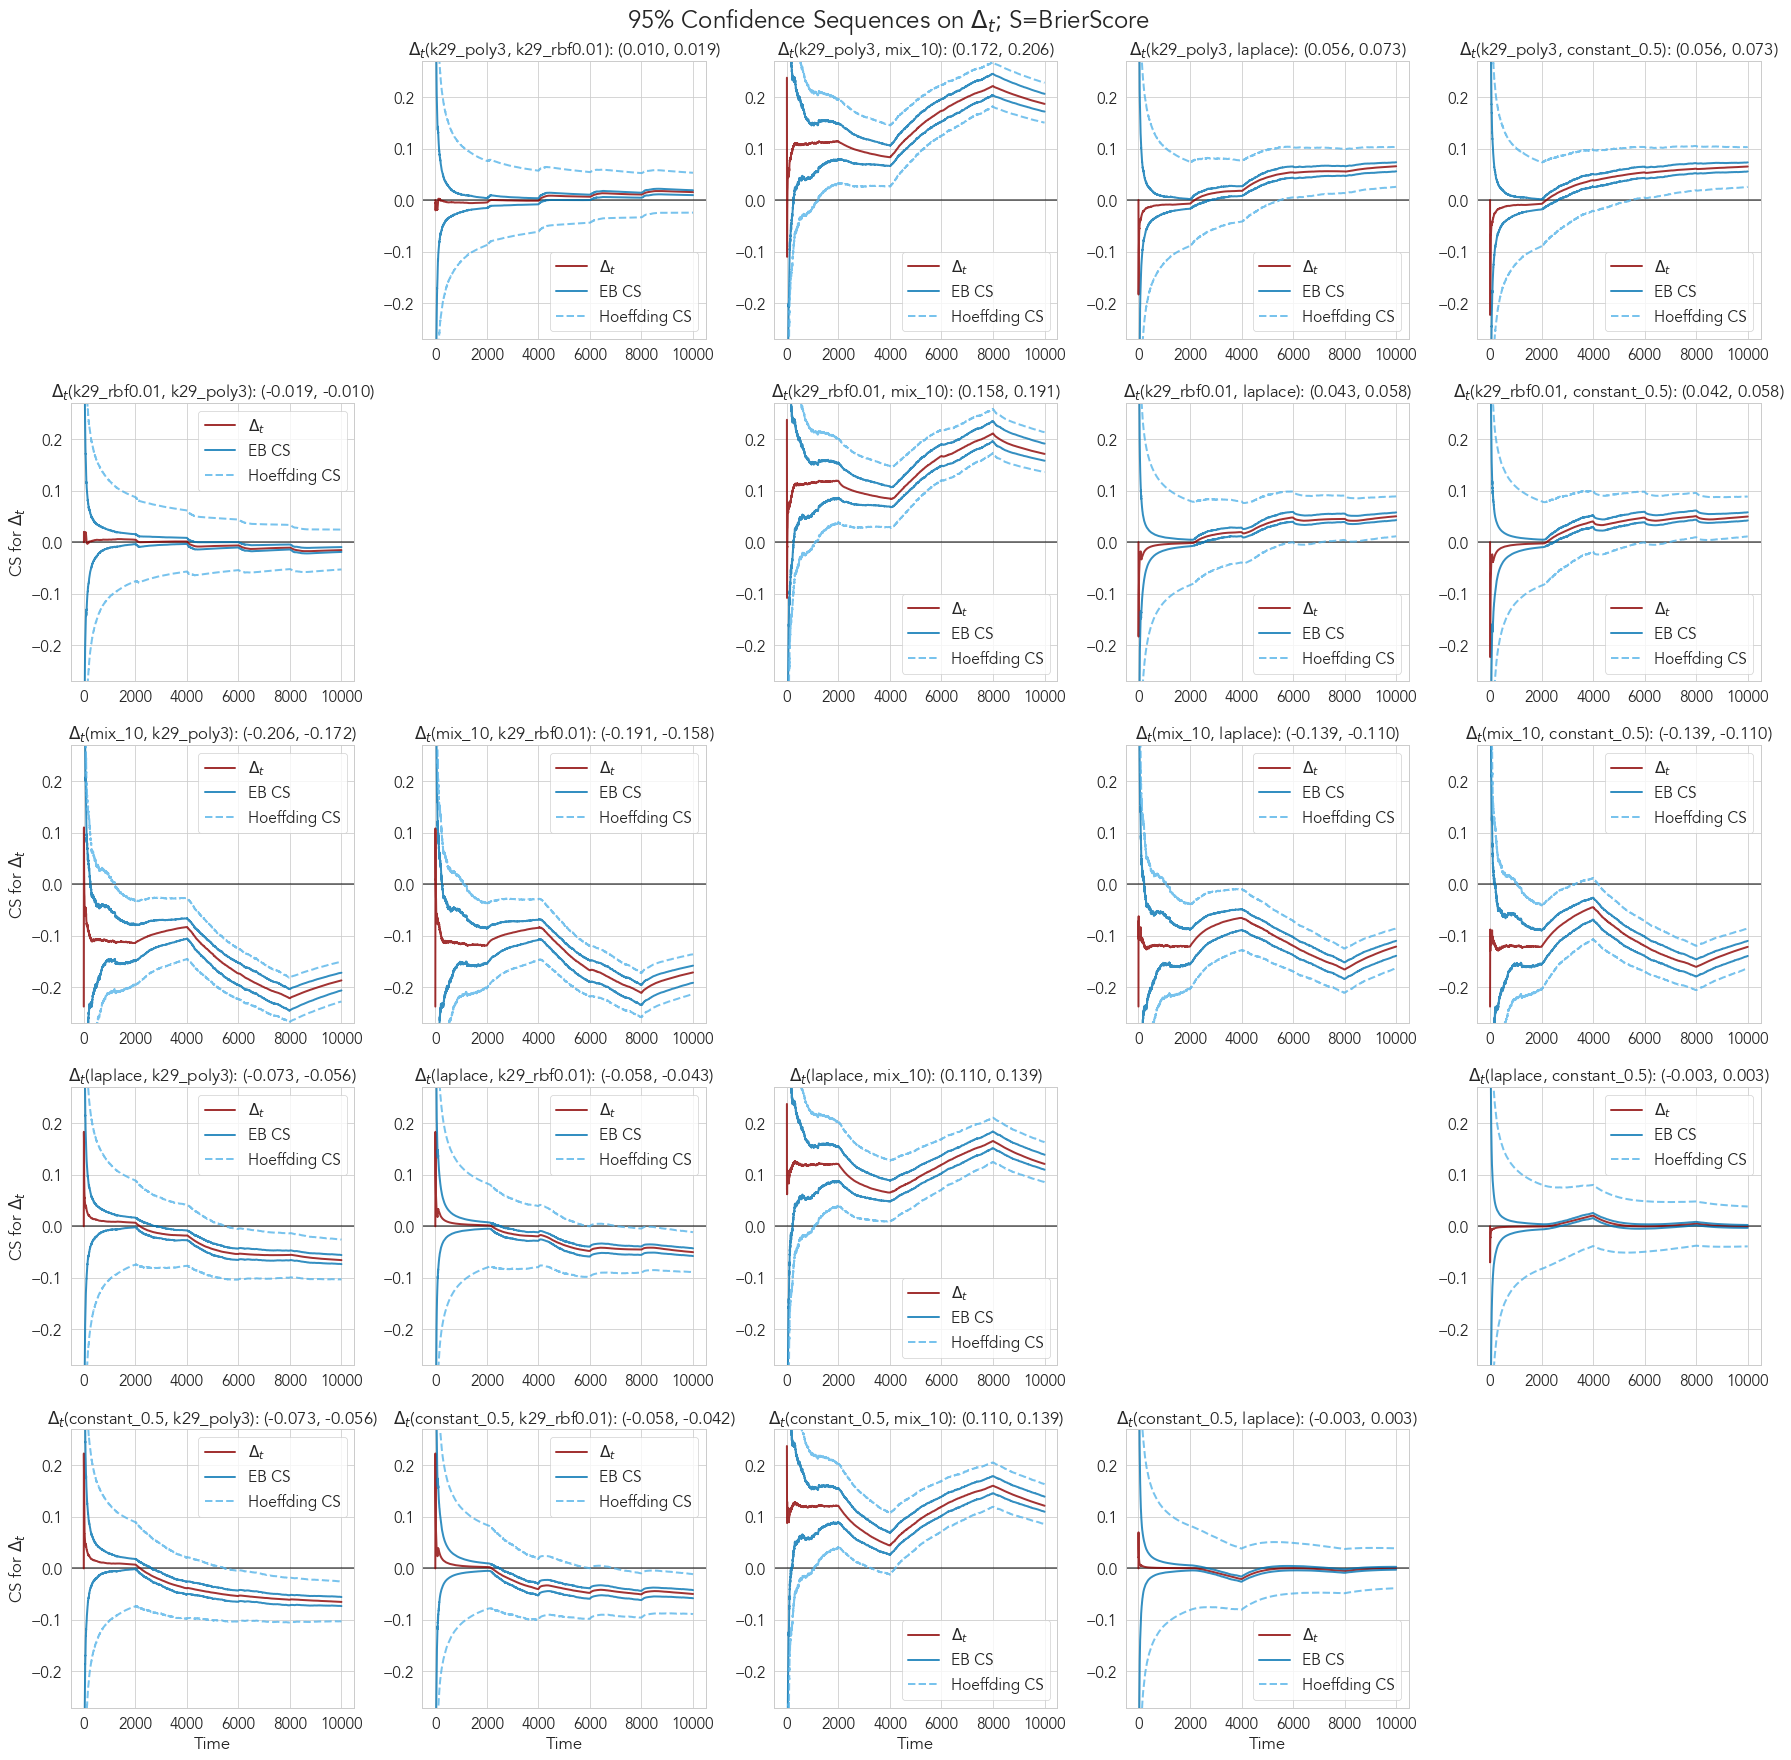

In [12]:
forecasters = ["k29_poly3", "k29_rbf0.01", "mix_10", "laplace", "constant_0.5"]
axes = cc.plot_pairwise_comparisons(
    data,
    forecasters, 
    scoring_rule=scoring_rule,
    plots_dir=plots_dir, 
    alpha=alpha,
    baselines=("h"),
    use_logx=use_logx,
    ylim_scale=0.27,
    font_scale=font_scale,
)